# __Define customer contribution level__
The contribution level is a classic dimension for understanding your customer’s profile.
> * We usually use frequency and monetary together to define different contribution levels.
> * We can use the historical data to find a general threshold for categorizing.

Google Slides: [Link](https://docs.google.com/presentation/d/1-bUFYXNqBQrPCJRRppxEoC-Mp1N_T8Ii3D95861M2Kw/edit?usp=sharing)

---

## __Import source data__
Data source: Simulated and pre-aggregated by *memberid* and *txndate*.    
You can downloand the data [here](https://drive.google.com/file/d/1qA4PhPCuID3cG3RL-TT_uK7X3i4fSI3N/view?usp=sharing) if you want to reproduce the source data.

In [1]:
import polars as pl
import seaborn as sb
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
    
aggdata = pl.read_csv("../data_source/simulation_data/aggData_byDay.csv", try_parse_dates = True)

In [2]:
aggdata

memberid,txndate,sum_total_price,sum_pay,sum_cart,gap,rev_gap,seq,rev_seq,sum_discnt,txnYM
str,date,i64,i64,i64,i64,i64,f64,f64,i64,date
"""m0000001""",2019-12-27,2590,2590,1,null,null,1.0,1.0,0,2019-12-01
"""m0000002""",2019-12-27,4840,4840,1,null,null,1.0,1.0,0,2019-12-01
"""m0000003""",2019-12-27,7080,0,1,null,null,1.0,1.0,7080,2019-12-01
"""m0000004""",2019-12-27,7610,7610,1,null,null,1.0,1.0,0,2019-12-01
"""m0000005""",2019-12-27,3810,3810,1,null,null,1.0,1.0,0,2019-12-01
…,…,…,…,…,…,…,…,…,…,…
"""m0513156""",2019-12-31,15060,13550,1,null,null,1.0,1.0,1510,2019-12-01
"""m0513157""",2019-12-31,6440,4510,1,null,null,1.0,1.0,1930,2019-12-01
"""m0513158""",2019-12-31,15060,10540,1,null,null,1.0,1.0,4520,2019-12-01


time duration:

In [3]:
(
    aggdata
    .select(
        pl.col('txnYM').min().alias('min_ym'),
        pl.col('txnYM').max().alias('max_ym'),
        pl.col('txnYM').n_unique().alias('len_months')
    )
)

min_ym,max_ym,len_months
date,date,u32
2016-07-01,2019-12-01,42


---

## __Trend of monthly frequency and monetary categorized threshold__.
We calculate the frequency and monetary over the last 12 months. And we repeat the rolling process 24 times.

In [4]:
# create year-month list
full_month_list = aggdata.select('txnYM').unique().to_series().sort()

# focus on the last 12 months data to evaluate the result
sub_month_list = full_month_list.tail(24)
sub_month_list

txnYM
date
2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
…
2019-08-01
2019-09-01
2019-10-01


In [5]:
import sys

sys.path.append("../func_source")
from func_basic import continuous_mean_grouping

trend_rst = pl.DataFrame()
for i in range(len(sub_month_list)):
    
    end_month = sub_month_list[i]
    ref_month = end_month - relativedelta(years = 1)

    aggId_section = (
        aggdata
        .filter((pl.col('txnYM') <= end_month) & (pl.col('txnYM') > ref_month))
        .group_by('memberid')
        .agg(
            sec_n_days = pl.col('txndate').count(),
            sec_sum_pay = pl.col('sum_pay').sum()
        )
        .sort(by = 'memberid')
        .with_columns(
            level_sec_n_days = pl.col('sec_n_days').map_batches(lambda x: continuous_mean_grouping(x, n_group = 4, high_to_low_name = ['T', 'H', 'M', 'L'])),
            level_sec_sum_pay = pl.col('sec_sum_pay').map_batches(lambda x: continuous_mean_grouping(x, n_group = 4, high_to_low_name = ['T', 'H', 'M', 'L'])),
        )
    )

    tb_n_days = (
        aggId_section
        .group_by('level_sec_n_days')
        .agg(
            lower_bound = pl.col('sec_n_days').min().cast(pl.Float32)
        )
        .with_columns(
            index = pl.lit("sec_n_days")
        )
        .rename({"level_sec_n_days": "level"})
        .sort(by = 'level')
    )

    tb_sum_pay = (
        aggId_section
        .group_by('level_sec_sum_pay')
        .agg(
            lower_bound = pl.col('sec_sum_pay').min().cast(pl.Float32)
        )
        .with_columns(
            index = pl.lit("sec_sum_pay")
        )
        .rename({"level_sec_sum_pay": "level"})
        .sort(by = 'level')
    )

    tmp_rst = (
        pl.concat([tb_n_days, tb_sum_pay])
        .with_columns(
            end_ym = end_month
        )
        .select(['end_ym', 'index', 'level', 'lower_bound'])
        
    )

    trend_rst = pl.concat([trend_rst, tmp_rst])


trend_rst

end_ym,index,level,lower_bound
date,str,enum,f32
2018-01-01,"""sec_n_days""","""T""",5.0
2018-01-01,"""sec_n_days""","""H""",3.0
2018-01-01,"""sec_n_days""","""M""",2.0
2018-01-01,"""sec_n_days""","""L""",1.0
2018-01-01,"""sec_sum_pay""","""T""",71470.0
…,…,…,…
2019-12-01,"""sec_n_days""","""L""",1.0
2019-12-01,"""sec_sum_pay""","""T""",72820.0
2019-12-01,"""sec_sum_pay""","""H""",33290.0


The trend of lower bound.

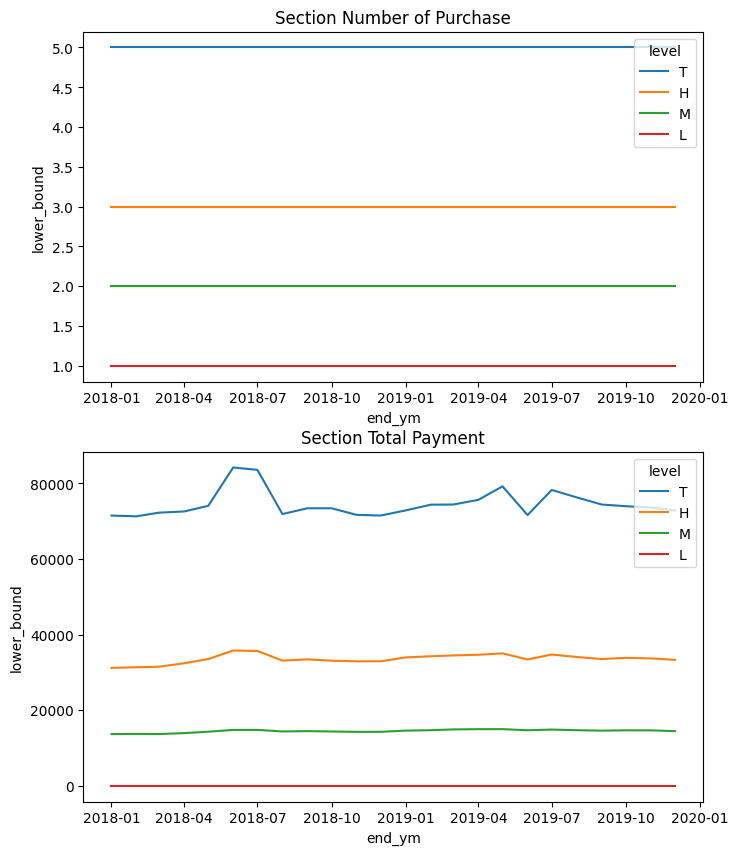

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
g1 = sb.lineplot(data = trend_rst.filter(pl.col('index') == "sec_n_days"), x = "end_ym", y = "lower_bound", hue = "level", ax = axes[0])
g2 = sb.lineplot(data = trend_rst.filter(pl.col('index') == "sec_sum_pay"), x = "end_ym", y = "lower_bound", hue = "level", ax = axes[1])
g1.title.set_text("Section Number of Purchase")
g2.title.set_text("Section Total Payment")

The average of these lower bounds.

In [7]:
threshold_reference = (
    trend_rst
    .group_by('index', 'level')
    .agg(lower_bound = pl.col('lower_bound').mean())
    .with_columns(pl.col('lower_bound').ceil())
    .sort(by = "level")
    .pivot(on = "index", index = "level", values = "lower_bound")
)

threshold_reference

level,sec_sum_pay,sec_n_days
enum,f32,f32
"""T""",74527.0,5.0
"""H""",33563.0,3.0
"""M""",14453.0,2.0
"""L""",0.0,1.0


---

## __Define the Tier 1 to 4 by the general threshhold.__


In [8]:
freq_info = threshold_reference.select('sec_n_days').to_series()
freq_T, freq_H, freq_M, freq_L = freq_info[:4]

monetary_info = threshold_reference.select('sec_sum_pay').to_series()
pay_T, pay_H, pay_M, pay_L = monetary_info[:4]

In [9]:
tmp_dict = {
    "L1": f"In the last 12 months: Frequency >= {freq_T:,.0f} and Monetary >= {pay_T:,.0f}",
    "L2": f"In the last 12 months: Frequency >= {freq_H:,.0f} and Monetary >= {pay_H:,.0f}",
    "L3": f"In the last 12 months: Frequency >= {freq_M:,.0f} and Monetary >= {pay_M:,.0f}",
    "L4": f"In the last 12 months: Frequency >= {freq_L:,.0f} and Monetary >= {pay_L:,.0f}",
}

section_condition_tb = (
    pl.from_dict(tmp_dict)
    .unpivot(variable_name = "section_value_index", value_name = "condition_description")
)

section_condition_tb

section_value_index,condition_description
str,str
"""L1""","""In the last 12 months: Frequen…"
"""L2""","""In the last 12 months: Frequen…"
"""L3""","""In the last 12 months: Frequen…"
"""L4""","""In the last 12 months: Frequen…"


In [10]:
end_month = sub_month_list[-1]
ref_month = end_month - relativedelta(years = 1)

aggId_section = (
    aggdata
    .filter((pl.col('txnYM') <= end_month) & (pl.col('txnYM') > ref_month))
    .group_by('memberid')
    .agg(
        section_n_days = pl.col('txndate').count(),
        section_sum_pay = pl.col('sum_pay').sum()
    )
    .sort(by = 'memberid')
    .with_columns(
        section_n_days_level = pl.col('section_n_days').cut(breaks = freq_info[:-1], labels = ['L', 'M', 'H', 'T'], left_closed = True),
        section_sum_pay_level = pl.col('section_sum_pay').cut(breaks = monetary_info[:-1], labels = ['L', 'M', 'H', 'T'], left_closed = True)
    )
    .with_columns(
            pl.when((pl.col('section_n_days_level') == "T") & (pl.col('section_sum_pay_level') == "T")).then(pl.lit('T1'))
            .when((pl.col('section_n_days_level') == "T") & (pl.col('section_sum_pay_level') == "H")).then(pl.lit('T2'))
            .when((pl.col('section_n_days_level') == "H") & (pl.col('section_sum_pay_level') == "H")).then(pl.lit('T2'))
            .when((pl.col('section_n_days_level') == "H") & (pl.col('section_sum_pay_level') == "T")).then(pl.lit('T2'))
            
            .when((pl.col('section_n_days_level') == "T") & (pl.col('section_sum_pay_level') == "M")).then(pl.lit('T3'))
            .when((pl.col('section_n_days_level') == "H") & (pl.col('section_sum_pay_level') == "M")).then(pl.lit('T3'))
            .when((pl.col('section_n_days_level') == "M") & (pl.col('section_sum_pay_level') == "M")).then(pl.lit('T3'))
            .when((pl.col('section_n_days_level') == "M") & (pl.col('section_sum_pay_level') == "H")).then(pl.lit('T3'))
            .when((pl.col('section_n_days_level') == "M") & (pl.col('section_sum_pay_level') == "T")).then(pl.lit('T3'))
            .otherwise(pl.lit('T4'))
            .alias('section_value_index')
        )
)

aggId = (
    aggdata
    .group_by('memberid')
    .agg(
        n_days = pl.col('txndate').count(),
        sum_pay = pl.col('sum_pay').sum()
    )
    .sort(by = 'memberid')
    .join(
        aggId_section, how = "left", on = "memberid"
    )
    .with_columns(
        pl.col('section_value_index').fill_null('IDLE')
    )
    .with_columns(
        pl.col('section_value_index').cast(pl.Enum(['T1', 'T2', 'T3', 'T4', 'IDLE']))
    )
)

aggId

memberid,n_days,sum_pay,section_n_days,section_sum_pay,section_n_days_level,section_sum_pay_level,section_value_index
str,u32,i64,u32,i64,cat,cat,enum
"""m0000001""",1,2590,1,2590,"""L""","""L""","""T4"""
"""m0000002""",1,4840,1,4840,"""L""","""L""","""T4"""
"""m0000003""",1,0,1,0,"""L""","""L""","""T4"""
"""m0000004""",1,7610,1,7610,"""L""","""L""","""T4"""
"""m0000005""",1,3810,1,3810,"""L""","""L""","""T4"""
…,…,…,…,…,…,…,…
"""m0513156""",1,13550,1,13550,"""L""","""L""","""T4"""
"""m0513157""",1,4510,1,4510,"""L""","""L""","""T4"""
"""m0513158""",1,10540,1,10540,"""L""","""L""","""T4"""


In [11]:
section_value_peo = aggId.group_by('section_value_index').agg(n = pl.len()).sort(by = 'section_value_index')
section_value_peo

section_value_index,n
enum,u32
"""T1""",236
"""T2""",956
"""T3""",4019
"""T4""",28235
"""IDLE""",51598


In [12]:
tmp_tb = (
    aggId
    .filter(pl.col('section_value_index') != "IDLE")
    .group_by(['section_n_days_level', 'section_sum_pay_level'])
    .agg(n = pl.len())
    .sort(by = ['section_n_days_level', 'section_sum_pay_level'])
)
tmp_tb

section_n_days_level,section_sum_pay_level,n
cat,cat,u32
"""L""","""L""",19674
"""L""","""M""",4010
"""L""","""H""",520
"""L""","""T""",28
"""M""","""L""",3130
…,…,…
"""H""","""T""",150
"""T""","""L""",63
"""T""","""M""",255


---

## __Use Case__

In [13]:
# Frequency = "Top" and Monetary = "Low"
(
    aggId
    .filter((pl.col('section_n_days_level') == "T") & (pl.col('section_sum_pay_level') == "L"))
    .filter(pl.col('section_sum_pay') < 5000)
    .sort(by = 'section_sum_pay', descending = True)
    .head(n = 1)
)

memberid,n_days,sum_pay,section_n_days,section_sum_pay,section_n_days_level,section_sum_pay_level,section_value_index
str,u32,i64,u32,i64,cat,cat,enum
"""m0338871""",10,33640,6,4000,"""T""","""L""","""T4"""


In [14]:
# Frequency = "Low" and Monetary = "Top"
(
    aggId
    .filter((pl.col('section_n_days_level') == "L") & (pl.col('section_sum_pay_level') == "H"))
    .sort(by = 'section_sum_pay', descending = True)
    .head(n = 1)
)

memberid,n_days,sum_pay,section_n_days,section_sum_pay,section_n_days_level,section_sum_pay_level,section_value_index
str,u32,i64,u32,i64,cat,cat,enum
"""m0238155""",2,86380,1,73040,"""L""","""H""","""T4"""
